<p><h5>Fake News Detection using Natural Languate Processing </h5>
Resource: 365 DataScience <br/>
Link: 365datascience.com <br/>
Author: Lauren Newbould</p>

Import Required Packages

In [1]:
# Import all the required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy, tokenizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_colwidth', None)
sns.set()
# Set the plot options
plt.rcParams['figure.figsize'] = (12, 4)
default_plot_color = '#00bfbf'

2023-11-21 13:23:07.777093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import the Dataset

In [2]:
news = pd.read_csv('fake_news_data.csv')
news.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim Refugees To Jesus’ Family,"There are two small problems with your analogy Susan Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim refugees to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly, Sarandon wrote of her experience. She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having given birth, manage that trip at sea? How did she do all that walking? Where did she give birth?Wasn t Mary just a kid too when she and Joseph took to the road? So far, there is no manger for this Syrian baby, no room at the inn.Sarandon s short column is part of a new collaborative series with the Huffington Post and the virtual reality network RYOT called The Crossing, which will see the actress host a series of reports chronicling the refugee crisis as it unfolds in Greece. The actress also criticized the political discourse surrounding the refugee crisis in the United States: It seemed like people who had the loudest voices were the most xenophobic and un-American, she said.Sarandon isn t the only actor to have visited the Greek island to assist international aid efforts for refugees; Homeland star Mandy Patinkin recently spent time there assisting the International Rescue Committee after wrapping production on the fifth season of the hit Showtime drama. Via: Breitbart News","Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face And Here’s The Pathetic Way Trump Tried To Spin It,"Buried in Trump s bonkers interview with New York Times reporters Maggie Haberman and Glenn Thrush is this outrageous exchange Trump claims happened recently:TRUMP: [U.S. Representative] Elijah Cummings was in my office and he said, You will go down as one of the great presidents in the history of our country. HABERMAN: Really?TRUMP: And then he went out and I watched him on television yesterday and I said, Was that the same man? Which would have been odd considering Cummings, a fiery Democratic congressman, has been one of Trump s most intense critics. He s very public about it. Cummings has been outspoken about Trump s disturbing connections to Russia, the GOP s botched attempts to cover those connections up, and has repeatedly demanded Trump divest himself of his numerous conflicts of interest. He hardly sounds like a person who has looked at Trump s trainwreck first three months in office and concluded that he deserves to be up on Mount Rushmore.One theory was that Trump flatly lied. Always a possibility Trump is a pathological liar. Another, suggested by writer Jamelle Bouie, is that Trump mixed up two black men, conflating Cummings with some other guy. Another strong possibility Trump has shown a complete lack of interest in the lives of black Americans.Fortunately, Cummings came in to provide the real answer: Trump took a criticism Cummings has made to his face and filtered it through his unchecked narcissism. Here s how Cummings describes the meeting Trump said was about praising him: During my meeting with the president and on several occasions since then, I have said repeatedly that he could be a great president if if he takes steps to truly represent all Americans rather than continuing on the divisive and harmful path he is currently on. Note t

Exploratory data analysis

In [3]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


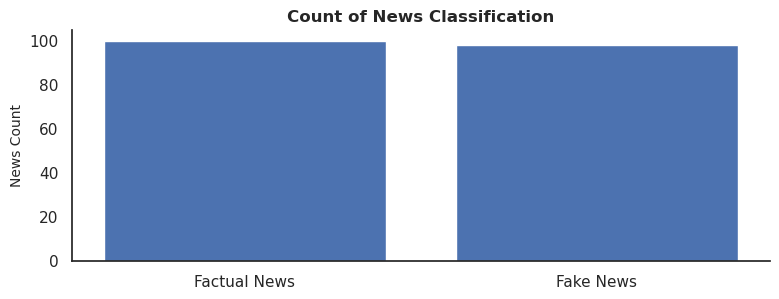

In [4]:
counts = news['fake_or_factual'].value_counts()
sns.set_style('white')
plt.figure(figsize=(9,3))
plt.bar(x=counts.index, height=counts.values, data=counts.values)
# plt.bar_label()
plt.xticks(rotation=0)
plt.title('Count of News Classification', size=12, weight='bold')
plt.ylabel('News Count', size=10)
plt.xlabel('')
sns.despine()
plt.show()

Tagging Identification - Parts of Speech Tagging

In [5]:
nlp = spacy.load('en_core_web_sm')
fake_news = news[news['fake_or_factual'] == 'Fake News']
fact_news = news[news['fake_or_factual'] == 'Factual News']

In [6]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

In [7]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [8]:
fake_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

In [9]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [10]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [11]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [12]:
fact_tagsdf = []
for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)
fact_tagsdf = pd.concat(fact_tagsdf)
fact_tagsdf.head(10)

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT
5,U.S.,GPE,PROPN
6,Defense,,PROPN
7,Secretary,,PROPN
8,Jim,PERSON,PROPN
9,Mattis,PERSON,PROPN


In [13]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
2446,a,DET,804
0,,SPACE,795
7523,to,PART,767
4915,in,ADP,667
5094,is,AUX,419


In [14]:
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
2100,and,CCONJ,757
4015,in,ADP,672
6230,to,PART,660
4761,on,ADP,482
5586,said,VERB,452


In [15]:
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2597
VERB     1814
PROPN    1657
ADJ       876
ADV       412
NUM       221
PRON       99
ADP        88
AUX        58
SCONJ      54
Name: token, dtype: int64

In [16]:
pos_counts_fact.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2182
VERB     1535
PROPN    1387
ADJ       753
ADV       271
NUM       203
PRON       81
ADP        70
AUX        44
SCONJ      39
Name: token, dtype: int64

In [17]:
pos_counts_fake[pos_counts_fake['pos_tag'] == 'NOUN'][:15]

,token,pos_tag,counts
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
8011,year,NOUN,44
3134,campaign,NOUN,44
4577,government,NOUN,41
5208,law,NOUN,40
7344,t,NOUN,40
8013,years,NOUN,40


In [18]:
pos_counts_fact[pos_counts_fact['pos_tag'] == 'NOUN'][:15]

,token,pos_tag,counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
3289,election,NOUN,48
5084,president,NOUN,47
4804,order,NOUN,45
4937,people,NOUN,45
2509,campaign,NOUN,42


Tagging Idetification - Named Entities Recognitation

In [19]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [20]:
pd.unique(top_entities_fake['ner_tag'])

array(['ORG', 'PERSON', 'CARDINAL', 'DATE', 'NORP', 'GPE', 'ORDINAL',
       'MONEY', 'PERCENT', 'FAC', 'TIME', 'LOC', 'PRODUCT', 'LAW',
       'EVENT', 'WORK_OF_ART', 'QUANTITY'], dtype=object)

/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Most common Named Enntities in Fake New')]

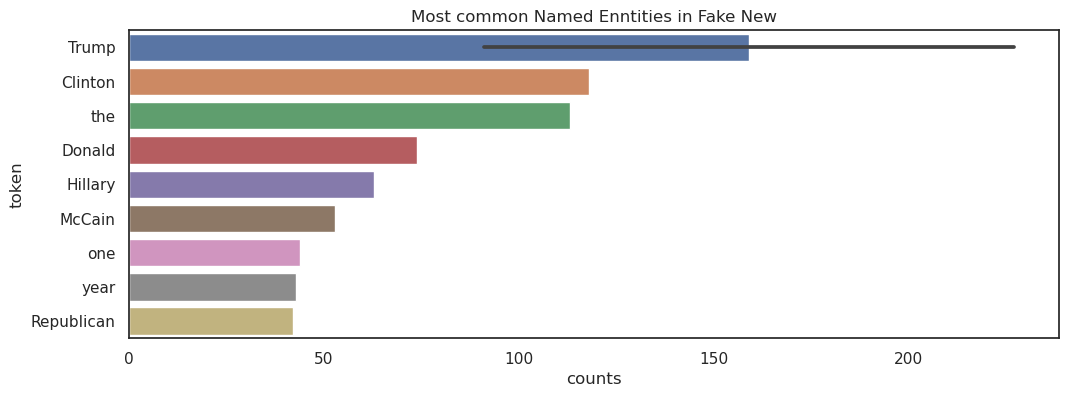

In [21]:
ner_palatte = {
    'ORG': sns.color_palette('Set2').as_hex()[0],
    'GPE': sns.color_palette('Set2').as_hex()[1],
    'NORP': sns.color_palette('Set2').as_hex()[2],
    'PERSON': sns.color_palette('Set2').as_hex()[3],
    'DATE': sns.color_palette('Set2').as_hex()[4],
    'CARDINAL': sns.color_palette('Set2').as_hex()[5],
    'PERCENT': sns.color_palette('Set2').as_hex()[6],
    'ORDINAL': sns.color_palette('Set2').as_hex()[7],
    # 'MONEY': sns.color_palette('Set2').as_hex()[8],
    # 'FAC': sns.color_palette('Set2').as_hex()[9],
    # 'TIME': sns.color_palette('Set2').as_hex()[10],
    # 'LOC': sns.color_palette('Set2').as_hex()[11],
    # 'PRODUCT': sns.color_palette('Set2').as_hex()[12],
    # 'LAW': sns.color_palette('Set2').as_hex()[13],
    # 'EVENT': sns.color_palette('Set2').as_hex()[14],
    # 'WORK_OF_ART': sns.color_palette('Set2').as_hex()[15],
    # 'QUANTITY': sns.color_palette('Set2').as_hex()[16]
}

#SNS barPlot visualization pendings
sns.barplot(
    x='counts',
    y='token',
    # palette=[ner_palatte],
    data=top_entities_fake[:10],
    orient='h',
    dodge=False
).set(title='Most common Named Enntities in Fake New')

Text Preprocessing - Cleaning the Text

In [22]:
news['text_clean'] = news.apply(lambda df: re.sub(r'^[^-]*-\s', ' ', df['text']), axis=1)
news.head(1)

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim Refugees To Jesus’ Family,"There are two small problems with your analogy Susan Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim refugees to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly, Sarandon wrote of her experience. She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having given birth, manage that trip at sea? How did she do all that walking? Where did she give birth?Wasn t Mary just a kid too when she and Joseph took to the road? So far, there is no manger for this Syrian baby, no room at the inn.Sarandon s short column is part of a new collaborative series with the Huffington Post and the virtual reality network RYOT called The Crossing, which will see the actress host a series of reports chronicling the refugee crisis as it unfolds in Greece. The actress also criticized the political discourse surrounding the refugee crisis in the United States: It seemed like people who had the loudest voices were the most xenophobic and un-American, she said.Sarandon isn t the only actor to have visited the Greek island to assist international aid efforts for refugees; Homeland star Mandy Patinkin recently spent time there assisting the International Rescue Committee after wrapping production on the fifth season of the hit Showtime drama. Via: Breitbart News","Dec 30, 2015",Fake News,"There are two small problems with your analogy Susan Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim refugees to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly, Sarandon wrote of her experience. She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having given birth, manage that trip at sea? How did she do all that walking? Where did she give birth?Wasn t Mary just a kid too when she and Joseph took to the road? So far, there is no manger for this Syrian baby, no room at the inn.Sarandon s short column is part of a new collaborative series with the Huffington Post and the virtual reality network RYOT called The Crossing, which will see the actress host a series of reports chronicling the refugee crisis as it unfolds in Greece. The actress also criticized the political discourse surrounding the refugee crisis in the United States: It seemed like people who had the loudest voices were the most xenophobic and un-American, she said.Sarandon isn t the only actor to have visited the Greek island to assist international aid efforts for refugees; Homeland star Mandy Patinkin recently spent time there assisting the International Re

In [23]:
news['text_clean'] = news['text_clean'].str.lower()
news['text_clean'] = news.apply(lambda df: re.sub(r'[^\w\s]', ' ', df['text_clean']), axis=1)
news['text_clean'] = news.apply(lambda df: re.sub(' +', ' ', df['text_clean']), axis=1)
news.head(1)

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim Refugees To Jesus’ Family,"There are two small problems with your analogy Susan Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim refugees to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly, Sarandon wrote of her experience. She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having given birth, manage that trip at sea? How did she do all that walking? Where did she give birth?Wasn t Mary just a kid too when she and Joseph took to the road? So far, there is no manger for this Syrian baby, no room at the inn.Sarandon s short column is part of a new collaborative series with the Huffington Post and the virtual reality network RYOT called The Crossing, which will see the actress host a series of reports chronicling the refugee crisis as it unfolds in Greece. The actress also criticized the political discourse surrounding the refugee crisis in the United States: It seemed like people who had the loudest voices were the most xenophobic and un-American, she said.Sarandon isn t the only actor to have visited the Greek island to assist international aid efforts for refugees; Homeland star Mandy Patinkin recently spent time there assisting the International Rescue Committee after wrapping production on the fifth season of the hit Showtime drama. Via: Breitbart News","Dec 30, 2015",Fake News,there are two small problems with your analogy susan jesus was not a muslim and joseph traveled to bethlehem with mary for anyone who s not paying attention there don t appear to be many female refugees accompanying male muslim refugees to greece susan sarandon spent the christmas holiday on the greek island of lesbos assisting international organizations with the mounting syrian refugee crisis a crisis she says that recalls the travails of joseph and mary on their way to the inn in bethlehem in a column for the huffington post and ryot the 69 year old oscar winning actress described meeting a 16 year old girl who had apparently given birth shortly before arriving on the island i smile and approach her but without a translator our conversation is basic friendly sarandon wrote of her experience she takes the bundle next to her and opens it to me inside is a perfect rosy newborn the actress continues she is beaming so proud how did this young girl just having given birth manage that trip at sea how did she do all that walking where did she give birth wasn t mary just a kid too when she and joseph took to the road so far there is no manger for this syrian baby no room at the inn sarandon s short column is part of a new collaborative series with the huffington post and the virtual reality network ryot called the crossing which will see the actress host a series of reports chronicling the refugee crisis as it unfolds in greece the actress also criticized the political discourse surrounding the refugee crisis in the united states it seemed like people who had the loudest voices were the most xenophobic and un american she said sarandon isn t the only actor to have visited the greek island to assist international aid efforts for refugees homeland star mandy patinkin recently spent time there assisting the international rescue committee after wrappin

Preprocessing - Removing Stopwords

In [24]:
en_stopwords = stopwords.words('english')
en_stopwords.append('u')
news['text_clean'] = news.apply(lambda df_row: ' '.join([word for word in df_row['text_clean'].split() if word not in en_stopwords]), axis=1)
news['text_clean'][0]

'two small problems analogy susan jesus muslim joseph traveled bethlehem mary anyone paying attention appear many female refugees accompanying male muslim refugees greece susan sarandon spent christmas holiday greek island lesbos assisting international organizations mounting syrian refugee crisis crisis says recalls travails joseph mary way inn bethlehem column huffington post ryot 69 year old oscar winning actress described meeting 16 year old girl apparently given birth shortly arriving island smile approach without translator conversation basic friendly sarandon wrote experience takes bundle next opens inside perfect rosy newborn actress continues beaming proud young girl given birth manage trip sea walking give birth mary kid joseph took road far manger syrian baby room inn sarandon short column part new collaborative series huffington post virtual reality network ryot called crossing see actress host series reports chronicling refugee crisis unfolds greece actress also criticized

Preprocessing - Tokenizing, Lemmatizing or Stemming

In [25]:
news['text_clean'] = news.apply(lambda df_row: word_tokenize(df_row['text_clean']), axis=1)

In [26]:
lemmatizer = WordNetLemmatizer()
news['text_clean'] = news['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
news['text_clean'][0][0:10]

['two',
 'small',
 'problem',
 'analogy',
 'susan',
 'jesus',
 'muslim',
 'joseph',
 'traveled',
 'bethlehem']

Preprocessing - Unigrams

In [27]:
tokens_clean = sum(news['text_clean'], [])
tokens_clean[0:10]

['two',
 'small',
 'problem',
 'analogy',
 'susan',
 'jesus',
 'muslim',
 'joseph',
 'traveled',
 'bethlehem']

In [28]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts())
print(unigrams[:10])

(trump,)         612
(said,)          596
(state,)         285
(president,)     275
(would,)         227
(year,)          184
(one,)           172
(clinton,)       151
(republican,)    144
(also,)          128
Name: count, dtype: int64


/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Most common unigrams after preprocessing')]

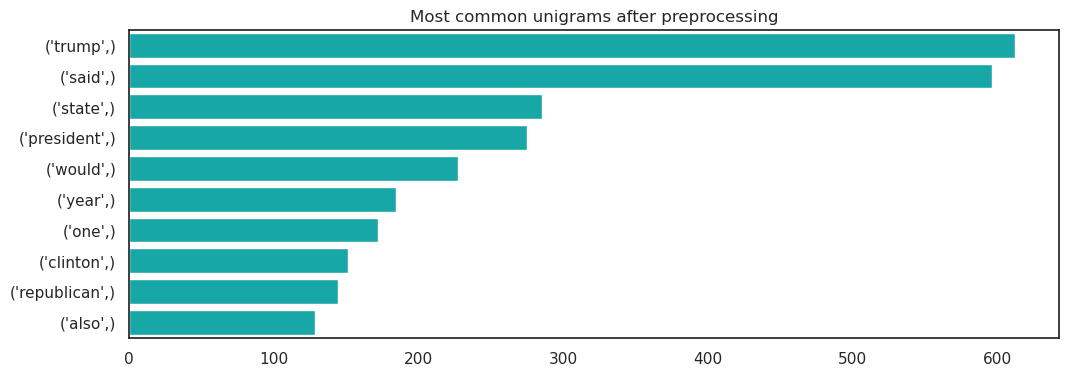

In [29]:
sns.barplot(x=unigrams.values[:10],
            y=unigrams.index[:10],
            orient='h',
            palette=[default_plot_color]).set(title='Most common unigrams after preprocessing')

(donald, trump)        115
(united, state)         84
(white, house)          77
(president, donald)     47
(hillary, clinton)      44
(new, york)             33
(year, old)             30
(featured, image)       30
(supreme, court)        30
(image, via)            29
Name: count, dtype: int64


/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Most common bigrams after preprocessing')]

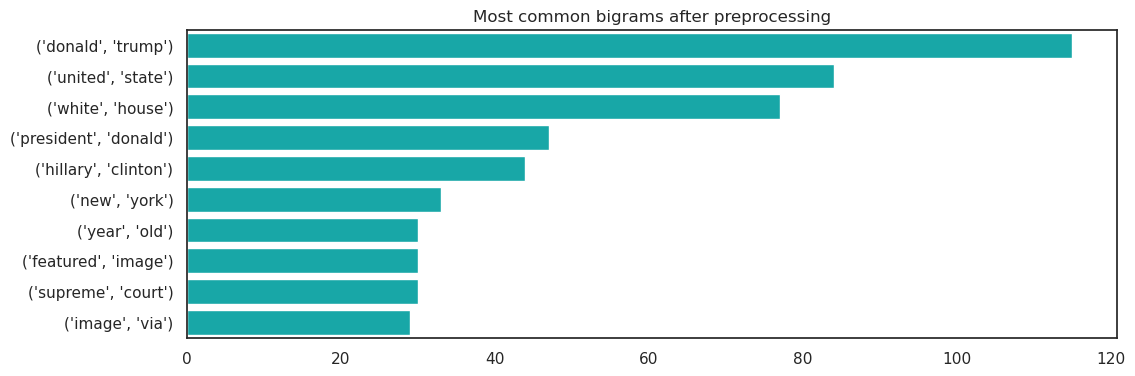

In [30]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts())
print(bigrams[:10])
sns.barplot(x=bigrams.values[:10],
            y=bigrams.index[:10],
            orient='h',
            palette=[default_plot_color]).set(title='Most common bigrams after preprocessing')

Sentiment Analysis

In [31]:
vader_sentiment = SentimentIntensityAnalyzer() # Sentiment intensity analyzer
news['vader_sentiment_score'] = news['text'].apply(lambda text: vader_sentiment.polarity_scores(text)['compound'])

In [32]:
bins = [-1,-0.1,0.1,1]
names = ['negative', 'neutral', 'positive']
news['vader_sentiment_labels'] = pd.cut(news['vader_sentiment_score'], bins, labels=names)
news.head(1)

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_labels
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim Refugees To Jesus’ Family,"There are two small problems with your analogy Susan Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim refugees to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly, Sarandon wrote of her experience. She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having given birth, manage that trip at sea? How did she do all that walking? Where did she give birth?Wasn t Mary just a kid too when she and Joseph took to the road? So far, there is no manger for this Syrian baby, no room at the inn.Sarandon s short column is part of a new collaborative series with the Huffington Post and the virtual reality network RYOT called The Crossing, which will see the actress host a series of reports chronicling the refugee crisis as it unfolds in Greece. The actress also criticized the political discourse surrounding the refugee crisis in the United States: It seemed like people who had the loudest voices were the most xenophobic and un-American, she said.Sarandon isn t the only actor to have visited the Greek island to assist international aid efforts for refugees; Homeland star Mandy Patinkin recently spent time there assisting the International Rescue Committee after wrapping production on the fifth season of the hit Showtime drama. Via: Breitbart News","Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, muslim, joseph, traveled, bethlehem, mary, anyone, paying, attention, appear, many, female, refugee, accompanying, male, muslim, refugee, greece, susan, sarandon, spent, christmas, holiday, greek, island, lesbos, assisting, international, organization, mounting, syrian, refugee, crisis, crisis, say, recall, travail, joseph, mary, way, inn, bethlehem, column, huffington, post, ryot, 69, year, old, oscar, winning, actress, described, meeting, 16, year, old, girl, apparently, given, birth, shortly, arriving, island, smile, approach, without, translator, conversation, basic, friendly, sarandon, wrote, experience, take, bundle, next, open, inside, perfect, rosy, newborn, actress, continues, beaming, proud, young, girl, given, birth, manage, trip, sea, walking, give, ...]",-0.366,negative


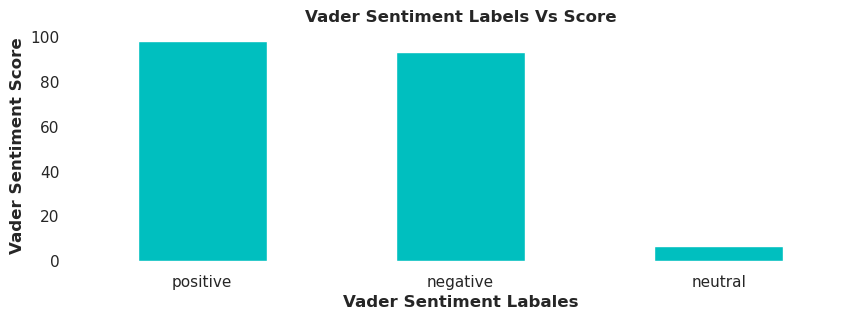

In [33]:
plt.figure(figsize=(10,3))
news['vader_sentiment_labels'].value_counts().plot.bar(color=default_plot_color)
plt.xticks(rotation=0)
plt.xlabel('Vader Sentiment Labales', weight='bold')
plt.ylabel('Vader Sentiment Score', weight='bold')
plt.title('Vader Sentiment Labels Vs Score', weight='bold')
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dinakar/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Sentiment by news type')]

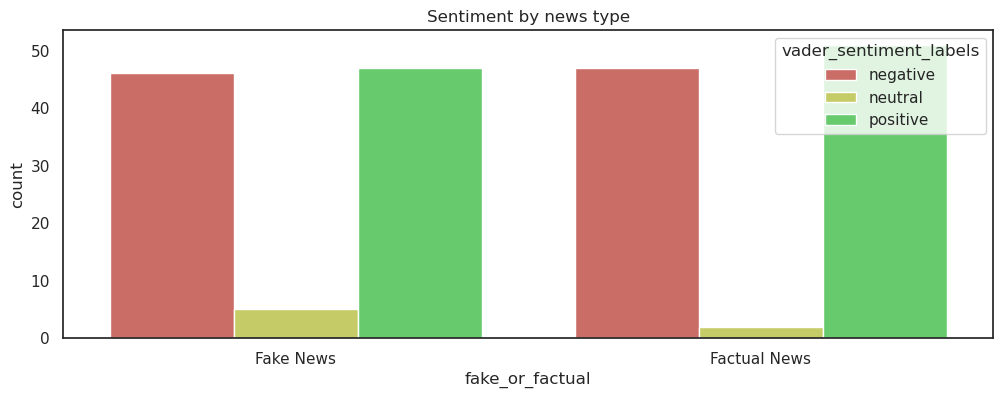

In [34]:
sns.countplot(
    x='fake_or_factual',
    hue='vader_sentiment_labels',
    palette=sns.color_palette('hls'),
    data=news,
).set(title='Sentiment by news type')

In [35]:
pd.crosstab(news['fake_or_factual'], news['vader_sentiment_labels'])

vader_sentiment_labels,negative,neutral,positive
fake_or_factual,,,
Factual News,47,2,51
Fake News,46,5,47


Topic Modeling - Latent Dirichlet Allocation

In [36]:
fake_news_text = news[news['fake_or_factual'] == 'Fake News']['text_clean'].reset_index(drop=True)

In [37]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [38]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text] # bag of words
print(doc_term_fake)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 3), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 4), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 2), (47, 2), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 2), (55, 1), (56, 3), (57, 3), (58, 1), (59, 3), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 3), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 6), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 4), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 2), (110, 1)

In [39]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word=dictionary_fake)
    model_list.append(model)
    coherence_model =  CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

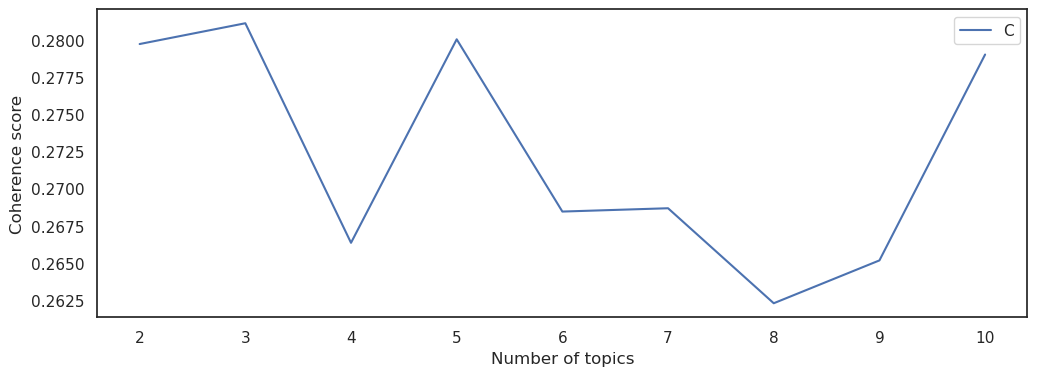

In [40]:
plt.plot(range(min_topics, max_topics), coherence_values)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.legend(('Coherence Values'), loc='best')
plt.show()

In [62]:
num_topics_lda = 3
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, num_topics=num_topics_lda, id2word=dictionary_fake)
lda_model.print_topics(num_topics=num_topics_lda, num_words=10)

[(0,
  '0.008*"trump" + 0.005*"clinton" + 0.005*"said" + 0.005*"president" + 0.004*"state" + 0.004*"one" + 0.004*"would" + 0.004*"woman" + 0.003*"u" + 0.003*"republican"'),
 (1,
  '0.014*"trump" + 0.005*"said" + 0.005*"president" + 0.004*"clinton" + 0.004*"one" + 0.004*"republican" + 0.004*"state" + 0.003*"year" + 0.003*"donald" + 0.003*"time"'),
 (2,
  '0.015*"trump" + 0.005*"said" + 0.005*"president" + 0.004*"state" + 0.004*"time" + 0.004*"would" + 0.004*"obama" + 0.003*"clinton" + 0.003*"one" + 0.003*"year"')]

Topic Modeling - Latent Semantic Analysis

In [42]:
# TFIDF vectorization
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus = doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [43]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_value = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_value.append(coherence_model.get_coherence())
    plt.plot(range(min_topics, max_topics+1), coherence_value)
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_value'), loc='best')
    plt.show()

In [44]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

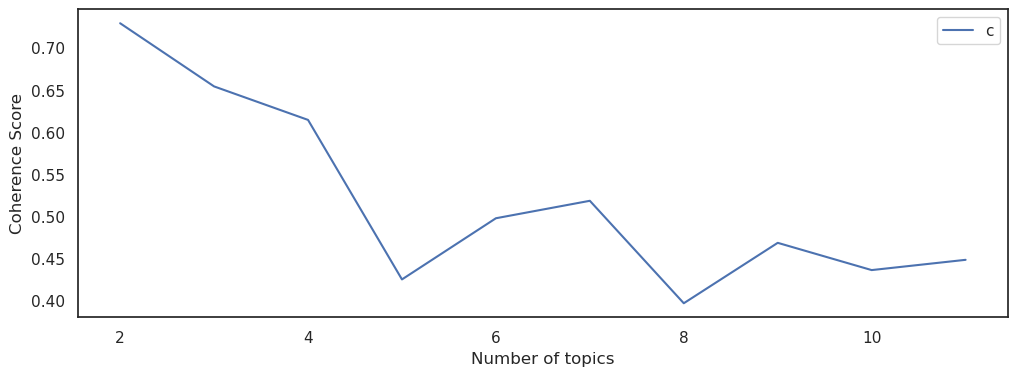

In [45]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [63]:
lsa_model = LsiModel(corpus=corpus_tfidf_fake, id2word=dictionary_fake, num_topics=2)

In [64]:
lsa_model.print_topics()

[(0,
  '0.193*"trump" + 0.136*"clinton" + 0.093*"hillary" + 0.093*"president" + 0.087*"woman" + 0.085*"obama" + 0.083*"boiler" + 0.077*"republican" + 0.077*"flynn" + 0.076*"party"'),
 (1,
  '-0.340*"boiler" + -0.283*"acr" + -0.238*"room" + -0.238*"pm" + -0.217*"00" + -0.191*"join" + -0.171*"broadcast" + -0.166*"radio" + -0.131*"tune" + -0.131*"animal"')]

Creating a Classified model

In [48]:
news.head(1)

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_labels
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim Refugees To Jesus’ Family,"There are two small problems with your analogy Susan Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim refugees to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly, Sarandon wrote of her experience. She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having given birth, manage that trip at sea? How did she do all that walking? Where did she give birth?Wasn t Mary just a kid too when she and Joseph took to the road? So far, there is no manger for this Syrian baby, no room at the inn.Sarandon s short column is part of a new collaborative series with the Huffington Post and the virtual reality network RYOT called The Crossing, which will see the actress host a series of reports chronicling the refugee crisis as it unfolds in Greece. The actress also criticized the political discourse surrounding the refugee crisis in the United States: It seemed like people who had the loudest voices were the most xenophobic and un-American, she said.Sarandon isn t the only actor to have visited the Greek island to assist international aid efforts for refugees; Homeland star Mandy Patinkin recently spent time there assisting the International Rescue Committee after wrapping production on the fifth season of the hit Showtime drama. Via: Breitbart News","Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, muslim, joseph, traveled, bethlehem, mary, anyone, paying, attention, appear, many, female, refugee, accompanying, male, muslim, refugee, greece, susan, sarandon, spent, christmas, holiday, greek, island, lesbos, assisting, international, organization, mounting, syrian, refugee, crisis, crisis, say, recall, travail, joseph, mary, way, inn, bethlehem, column, huffington, post, ryot, 69, year, old, oscar, winning, actress, described, meeting, 16, year, old, girl, apparently, given, birth, shortly, arriving, island, smile, approach, without, translator, conversation, basic, friendly, sarandon, wrote, experience, take, bundle, next, open, inside, perfect, rosy, newborn, actress, continues, beaming, proud, young, girl, given, birth, manage, trip, sea, walking, give, ...]",-0.366,negative


In [49]:
x = [','.join(map(str,l)) for l in news['text_clean']]

In [50]:
y = news['fake_or_factual']

In [51]:
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(x)

In [52]:
print(countvec_fit)

  (0, 7613)	1
  (0, 6806)	1
  (0, 5732)	1
  (0, 548)	1
  (0, 7204)	2
  (0, 4061)	1
  (0, 4901)	2
  (0, 4095)	3
  (0, 7527)	1
  (0, 976)	2
  (0, 4612)	3
  (0, 607)	1
  (0, 5397)	1
  (0, 775)	1
  (0, 629)	1
  (0, 4576)	1
  (0, 2903)	1
  (0, 6049)	6
  (0, 306)	1
  (0, 4538)	1
  (0, 3318)	2
  (0, 6458)	4
  (0, 6919)	2
  (0, 1432)	1
  (0, 3574)	1
  :	:
  (197, 5346)	1
  (197, 4177)	1
  (197, 6716)	2
  (197, 3776)	1
  (197, 8127)	2
  (197, 372)	1
  (197, 2240)	1
  (197, 5822)	1
  (197, 2267)	1
  (197, 3500)	1
  (197, 6775)	1
  (197, 7676)	1
  (197, 2477)	1
  (197, 628)	1
  (197, 2287)	1
  (197, 535)	1
  (197, 3174)	1
  (197, 205)	1
  (197, 4286)	1
  (197, 7773)	1
  (197, 7629)	1
  (197, 6084)	1
  (197, 5571)	1
  (197, 3291)	1
  (197, 5457)	1


In [53]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [54]:
print(bag_of_words)

     00  000  01  07  0gf8of9pfy  10  100  1002  102  102please  ...  zimdars  \
0     0    0   0   0           0   0    0     0    0          0  ...        0   
1     0    0   0   0           0   0    0     0    0          0  ...        0   
2     0    0   0   0           0   0    0     0    0          0  ...        0   
3     0    0   0   0           0   0    0     0    0          0  ...        0   
4     0    0   0   0           0   0    0     0    0          0  ...        0   
..   ..  ...  ..  ..         ...  ..  ...   ...  ...        ...  ...      ...   
193   0    0   0   0           0   0    0     0    0          0  ...        0   
194   0    0   0   0           0   0    0     0    0          0  ...        0   
195   0    1   0   0           0   0    0     0    0          0  ...        0   
196   0    0   0   0           0   0    0     0    0          0  ...        0   
197   0    1   0   0           0   0    0     0    0          0  ...        0   

     zimmerman  zina  zioni

In [55]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, y, test_size=0.3)

In [56]:
lr = LogisticRegression()
lr_result = lr.fit(X_train, y_train)

In [57]:
y_prid_lr = lr_result.predict(X_test)

In [58]:
accuracy_score(y_prid_lr, y_test)

0.9

In [59]:
print(classification_report(y_test, y_prid_lr))

              precision    recall  f1-score   support

Factual News       0.85      0.92      0.88        24
   Fake News       0.94      0.89      0.91        36

    accuracy                           0.90        60
   macro avg       0.89      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [60]:
svm = SGDClassifier().fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_score(y_pred_svm, y_test)

0.9166666666666666

In [61]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.91      0.88      0.89        24
   Fake News       0.92      0.94      0.93        36

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60

